In [56]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np

# Visualization
import seaborn as sns
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import statsmodels.api as sm

# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

# Model selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

In [6]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

In [7]:
stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

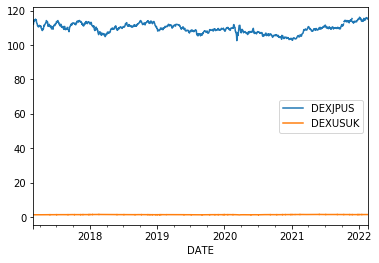

In [8]:
ccy_data.plot();

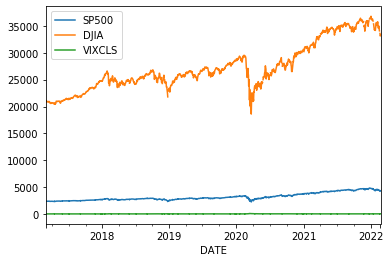

In [9]:
idx_data.plot();

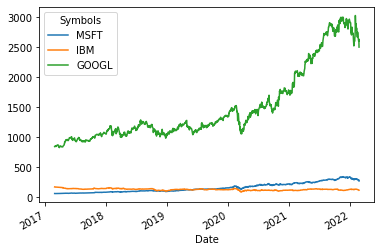

In [10]:
stk_data['Open'].plot();

In [11]:
return_period = 5

In [12]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)

In [13]:
Y.name = 'MSFT_pred'

In [14]:
X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()

X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, 
                                                                            return_period * 3, 
                                                                            return_period * 6, 
                                                                            return_period * 12]
          ], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1,X2,X3,X4], axis=1)

dataset = pd.concat([X,Y], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

#### Exploratory data analysis

##### 3.1 Descriptive analysis

In [15]:
pd.set_option('precision', 3)
dataset.describe()

,IBM,GOOGL,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT,MSFT_pred
count,2.250e+02,225.000,2.250e+02,2.250e+02,225.000,225.000,225.000,225.000,225.000,225.000,225.000,225.000
mean,3.519e-04,0.004,-8.697e-06,-4.748e-04,0.002,0.001,0.009,0.006,0.018,0.039,0.082,0.006
std,3.758e-02,0.037,8.939e-03,1.220e-02,0.026,0.028,0.177,0.033,0.050,0.064,0.072,0.034
min,-1.683e-01,-0.159,-3.293e-02,-5.492e-02,-0.162,-0.190,-0.559,-0.145,-0.165,-0.288,-0.139,-0.153
25%,-1.718e-02,-0.013,-5.348e-03,-6.905e-03,-0.007,-0.008,-0.087,-0.013,-0.008,0.005,0.044,-0.013
50%,2.102e-03,0.007,4.806e-04,-1.442e-03,0.004,0.004,-0.002,0.008,0.017,0.041,0.085,0.007
75%,1.734e-02,0.023,5.467e-03,6.167e-03,0.015,0.014,0.089,0.024,0.052,0.076,0.130,0.026
max,1.304e-01,0.134,3.800e-02,5.121e-02,0.098,0.121,0.910,0.100,0.186,0.285,0.283,0.100


In [16]:
dataset.head()

,IBM,GOOGL,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT,MSFT_pred
2017-05-23,-0.011,0.006,-0.014,0.006,-9.377e-04,-1.996e-03,0.007,-0.011,-0.003,0.053,0.073,0.017
2017-05-31,0.004,0.017,-0.012,-0.002,3.077e-03,-1.794e-04,0.038,0.017,0.017,0.072,0.089,0.036
2017-06-08,-0.004,0.016,-0.010,0.003,1.534e-03,1.812e-03,0.027,0.026,0.064,0.065,0.116,-0.029
2017-06-15,0.014,-0.045,0.005,-0.013,-5.466e-04,8.339e-03,0.070,-0.029,0.016,0.018,0.091,0.005
2017-06-22,0.001,0.017,0.006,-0.009,8.383e-04,1.749e-03,-0.039,0.005,0.002,0.019,0.079,-0.026


In [17]:
dataset.dtypes

IBM          float64
GOOGL        float64
DEXJPUS      float64
DEXUSUK      float64
SP500        float64
DJIA         float64
VIXCLS       float64
MSFT_DT      float64
MSFT_3DT     float64
MSFT_6DT     float64
MSFT_12DT    float64
MSFT_pred    float64
dtype: object

##### 3.2 Data visualization

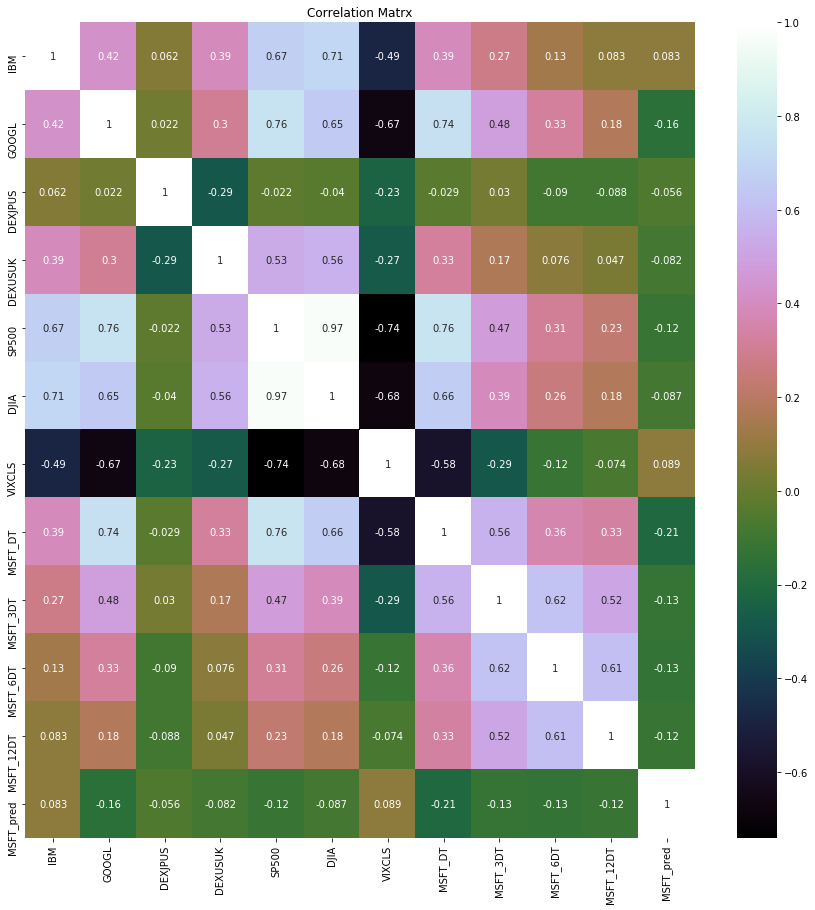

In [18]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrx')
sns.heatmap(correlation, vmax=1, annot=True, cmap='cubehelix')

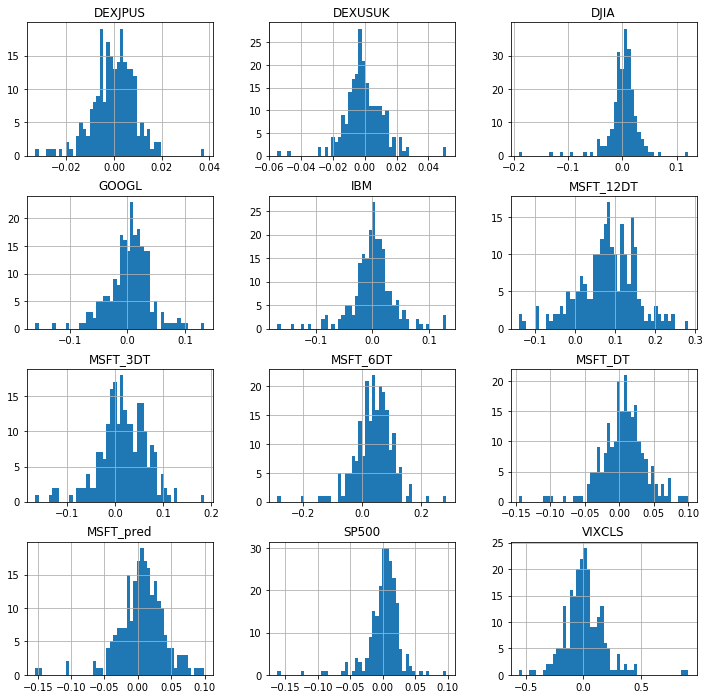

In [19]:
dataset.hist(bins=50, sharex=False, sharey=False,figsize=(12,12));

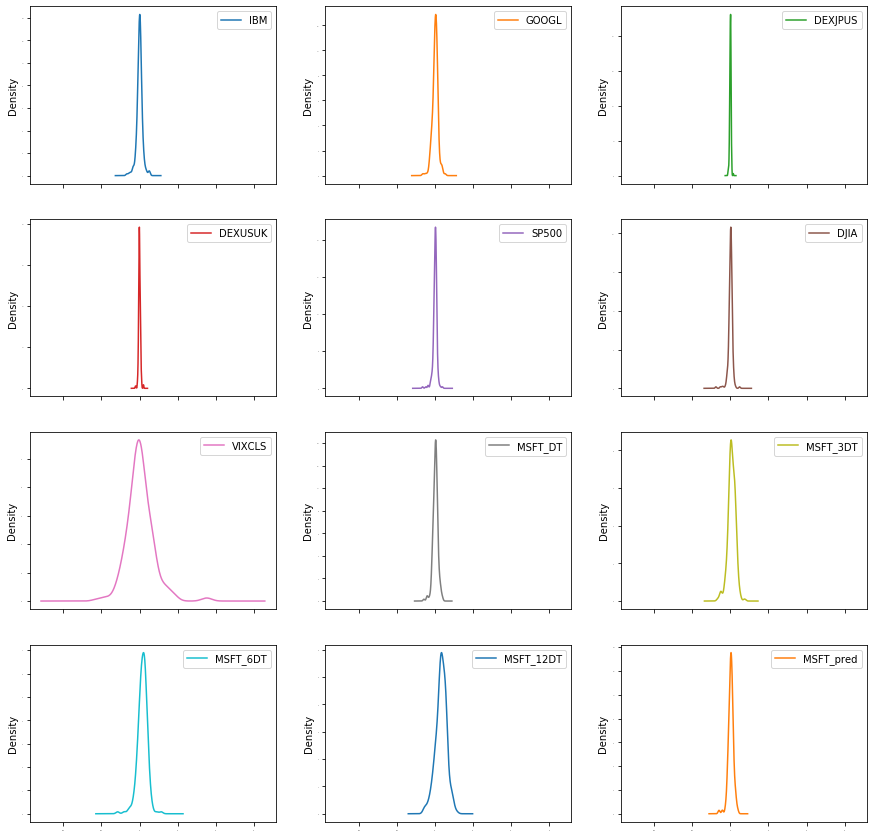

In [20]:
dataset.plot(kind='density', subplots=True, layout=(4,3), legend=True, fontsize=1, sharex=True, figsize=(15,15));

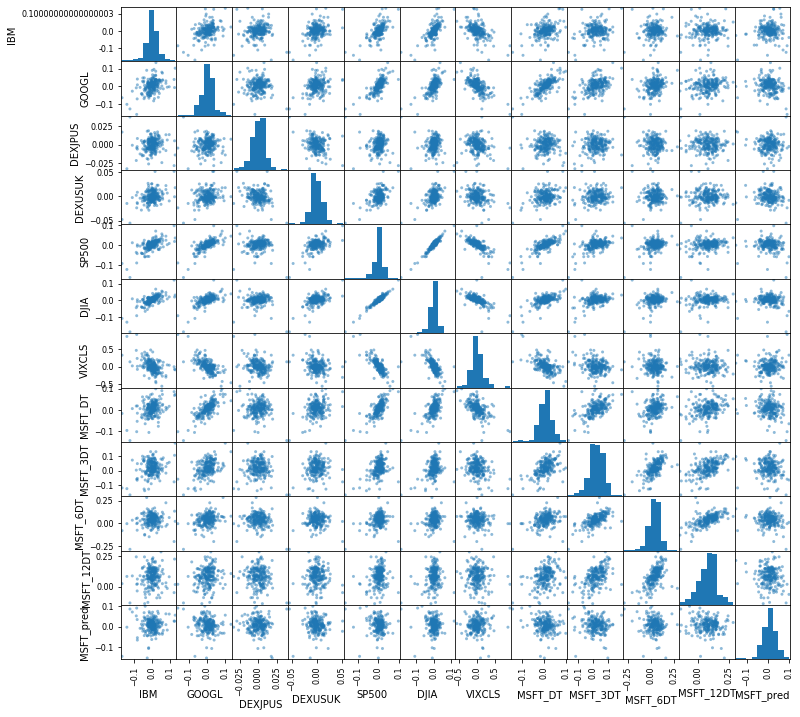

In [21]:
scatter_matrix(dataset, figsize=(12,12));

##### 3.3 Time Series Analysis

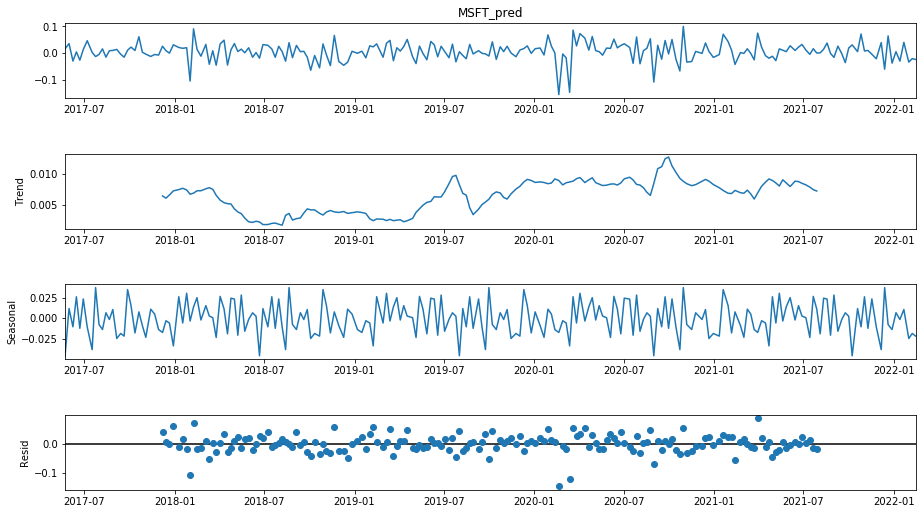

In [22]:
res = sm.tsa.seasonal_decompose(Y, period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

#### 4. Data Preparation
###### 4.2. Feature Selection

In [23]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']
featureScores.nlargest(10, 'Score').set_index('Specs')

,Score
Specs,
MSFT_DT,9.973
GOOGL,5.652
MSFT_6DT,3.899
MSFT_3DT,3.612
MSFT_12DT,3.229
SP500,3.213
VIXCLS,1.782
DJIA,1.689
IBM,1.555


#### 5. Evalute Algorithms and models

##### 5.1 Train test split and evaluation metrics

In [34]:
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

##### 5.2 Test Options and evaluation metrics

In [63]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

##### 5.3 Compare Models and Algorithms

###### 5.3.1 Machine learning models from scikit-learn

In [50]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('RID', Ridge()))

# Neural Network algorithms
models.append(('LR', MLPRegressor()))

# Ensamble models
#  Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))

#  Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [65]:
names = []
kfold_results = []

for name, model in models:
    names.append(name)
    
    # K Fold analysis:
    kfold = KFold(n_splits=num_folds)
    cv_result = -1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_result)
    
    # TODO: nastavljamo

kfold_results

[array([0.00040282, 0.00112996, 0.00060345, 0.00089698, 0.00149226,
        0.00077474, 0.00036241, 0.00416541, 0.00192757, 0.00141896]),
 array([0.0003662 , 0.00139233, 0.00077173, 0.00100113, 0.00089701,
        0.00072008, 0.00026128, 0.00393728, 0.00175283, 0.00151721]),
 array([0.0003662 , 0.00139233, 0.00077173, 0.00100113, 0.00089701,
        0.00072008, 0.00026128, 0.00393728, 0.00175283, 0.00151721]),
 array([0.00028407, 0.00165502, 0.00088441, 0.00149722, 0.00101342,
        0.00092975, 0.00041642, 0.00481015, 0.00185162, 0.00163887]),
 array([0.00129399, 0.00257836, 0.00299698, 0.00138918, 0.00244742,
        0.0019751 , 0.0018678 , 0.00723104, 0.00328512, 0.0017628 ]),
 array([0.00165379, 0.00350163, 0.00182868, 0.00169835, 0.00241447,
        0.00210731, 0.00183066, 0.00404196, 0.00367449, 0.00288162]),
 array([0.00034762, 0.00129978, 0.00068389, 0.00101998, 0.00097868,
        0.00068668, 0.00027118, 0.00417568, 0.00174114, 0.00144766]),
 array([0.00055654, 0.00398263, 0.